In [1]:
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime

import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras.layers import Dense
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
X = np.load("suspended_robot_X_data.npy",allow_pickle=True)
Y = np.load("suspended_robot_Y_data.npy",allow_pickle=True)

In [3]:
X.shape, Y.shape

((110592, 6), (110592, 4))

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.7,test_size=0.3,random_state=100,shuffle=True)

In [6]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((77414, 6), (77414, 4), (33178, 6), (33178, 4))

In [7]:
model = Sequential()
model.add(Dense(100,input_dim = X_train.shape[1],activation="relu"))
model.add(Dense(50,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(Y_train.shape[1],activation="linear"))

optimizer = optimizers.adam(lr=0.01)
model.compile(optimizer = optimizer,loss="mean_squared_error",metrics=["mse","mae"])
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               700       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 24        
Total params: 6,029
Trainable params: 6,029
Non-trainable params: 0
_________________________________________________________________


In [0]:
from datetime import datetime
curr_date_time = datetime.now()
model_name = "SuspendedBot_" + "_" + str(curr_date_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath = model_name + '_' + 'model-' + '{epoch:05d}-{loss:.5f}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [9]:
epoch_len = 10
model_history = model.fit(x=X_train,
          y=Y_train,
          epochs = epoch_len,
          verbose = 1,
          validation_data = (X_test,Y_test),
          batch_size = 100,
          callbacks = callbacks_list)



Train on 77414 samples, validate on 33178 samples
Epoch 1/10
77414/77414 [==============================] - 2s 25us/step - loss: 0.0605 - mean_squared_error: 0.0605 - mean_absolute_error: 0.1424 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0757

Epoch 00001: val_loss improved from inf to 0.01139, saving model to SuspendedBot__2019-09-1102_24_24.293816/_model-00001-0.06048-0.01139.h5
Epoch 2/10
77414/77414 [==============================] - 1s 16us/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0741 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0681

Epoch 00002: val_loss improved from 0.01139 to 0.00925, saving model to SuspendedBot__2019-09-1102_24_24.293816/_model-00002-0.01077-0.00925.h5
Epoch 3/10
77414/77414 [==============================] - 1s 16us/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0707 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - v

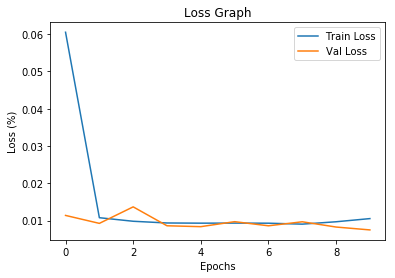

In [10]:
plt.plot(range(0,epoch_len,1),model_history.history["loss"])
plt.plot(range(0,epoch_len,1),model_history.history["val_loss"])
plt.legend(["Train Loss","Val Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.title("Loss Graph")
plt.show()

In [11]:
print("Minimum Validation Loss = %f achieved at epoch iteration = %d" %(np.array(model_history.history["val_loss"]).min(),np.array(model_history.history["val_loss"]).argmin() + 1))
sel_model_idx = np.array(model_history.history["val_loss"]).argmin() + 1

Minimum Validation Loss = 0.007500 achieved at epoch iteration = 10


In [12]:
search_string = "model-0*" + str(sel_model_idx) + "-[a-z0-9\-\.]*"
selected_model_name = model_name + list(filter(lambda x: re.search(search_string,x),os.listdir(model_name)))[0]
print("Selected model name : %s" %(selected_model_name))

Selected model name : SuspendedBot__2019-09-1102_24_24.293816/_model-00010-0.01053-0.00750.h5


In [0]:
from keras.models import clone_model
selected_model = clone_model(model)
selected_model.load_weights(selected_model_name)

In [0]:
Y_test_pred = selected_model.predict(X_test)

In [0]:
error0 = Y_test[:,0] - Y_test_pred[:,0]
error1 = Y_test[:,1] - Y_test_pred[:,1]
error2 = Y_test[:,2] - Y_test_pred[:,2]
error3 = Y_test[:,3] - Y_test_pred[:,3]

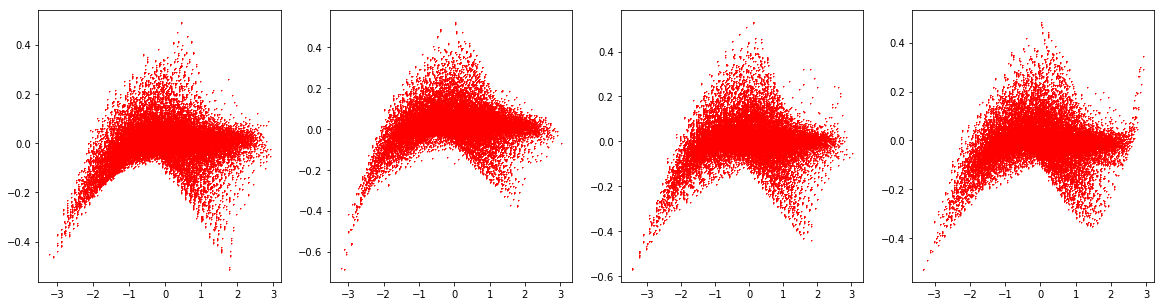

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5),sharex=False,sharey=False)
ax[0].plot(Y_test[:,0],error0,"r+",markersize=1)
ax[1].plot(Y_test[:,1],error1,"r+",markersize=1)
ax[2].plot(Y_test[:,2],error2,"r+",markersize=1)
ax[3].plot(Y_test[:,3],error3,"r+",markersize=1)
plt.show()

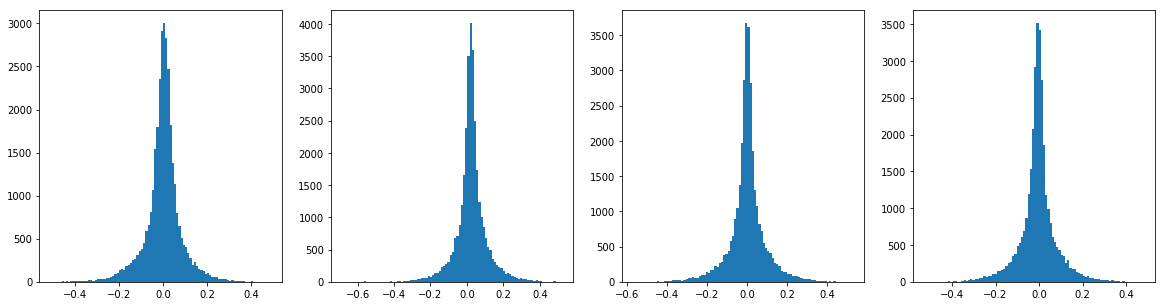

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5),sharex=False,sharey=False)
ax[0].hist(error0,bins=100)
ax[1].hist(error1,bins=100)
ax[2].hist(error2,bins=100)
ax[3].hist(error3,bins=100)
plt.show()

In [0]:
import pickle
with open("Y_theta_value_scalar_1X4_format.pkl","rb") as f:
    scalar_obj = pickle.load(f)

In [0]:
Y_test_unscaled = scalar_obj.inverse_transform(Y_test)
Y_test_pred_unscaled = scalar_obj.inverse_transform(Y_test_pred)

In [0]:
error_unscaled0 = Y_test_unscaled[:,0] - Y_test_pred_unscaled[:,0]
error_unscaled1 = Y_test_unscaled[:,1] - Y_test_pred_unscaled[:,1]
error_unscaled2 = Y_test_unscaled[:,2] - Y_test_pred_unscaled[:,2]
error_unscaled3 = Y_test_unscaled[:,3] - Y_test_pred_unscaled[:,3]

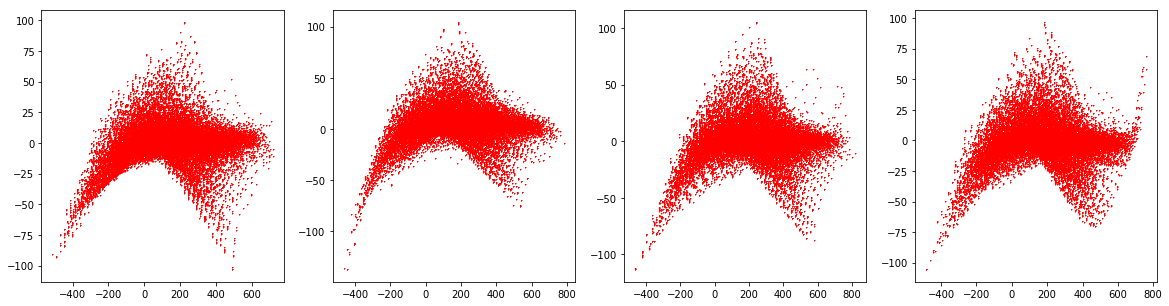

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5),sharex=False,sharey=False)
ax[0].plot(Y_test_unscaled[:,0],error_unscaled0,"r+",markersize=1)
ax[1].plot(Y_test_unscaled[:,1],error_unscaled1,"r+",markersize=1)
ax[2].plot(Y_test_unscaled[:,2],error_unscaled2,"r+",markersize=1)
ax[3].plot(Y_test_unscaled[:,3],error_unscaled3,"r+",markersize=1)
plt.show()

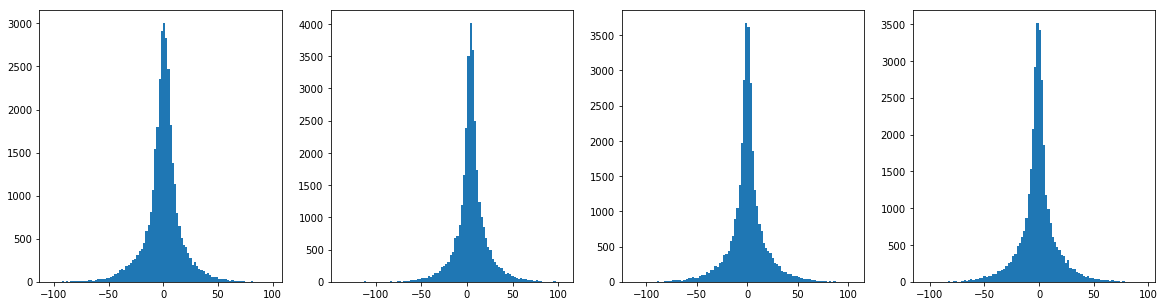

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5),sharex=False,sharey=False)
ax[0].hist(error_unscaled0,bins=100)
ax[1].hist(error_unscaled1,bins=100)
ax[2].hist(error_unscaled2,bins=100)
ax[3].hist(error_unscaled3,bins=100)
plt.show()

In [0]:
from sklearn.metrics import r2_score

In [32]:
print("Theta0 : Accuracy = %s\n\
Theta1 : Accuracy = %s\n\
Theta2 : Accuracy = %s\n\
Theta3 : Accuracy = %s" %(r2_score(Y_test[:,0],Y_test_pred[:,0]), \
r2_score(Y_test[:,1],Y_test_pred[:,1]), \
r2_score(Y_test[:,2],Y_test_pred[:,2]), \
r2_score(Y_test[:,3],Y_test_pred[:,3])))

Theta0 : Accuracy = 0.9932975826115154
Theta1 : Accuracy = 0.9920708373596726
Theta2 : Accuracy = 0.9918476891373541
Theta3 : Accuracy = 0.9929351345485551


In [30]:
r2_score(Y_test_unscaled[:,0],Y_test_pred_unscaled[:,0]), \
r2_score(Y_test_unscaled[:,1],Y_test_pred_unscaled[:,1]), \
r2_score(Y_test_unscaled[:,2],Y_test_pred_unscaled[:,2]), \
r2_score(Y_test_unscaled[:,3],Y_test_pred_unscaled[:,3])

(0.9932975827316414,
 0.9920708375923613,
 0.9918476897328066,
 0.9929351351129729)